In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
import torchvision
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

In [5]:
batch_size = 32
data_loader = torch.utils.data.DataLoader(MNIST('.', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        conv_dim_1 = 16
        conv_dim_2 = 64
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

        self.label_emb = nn.Embedding(10, 1 * 28 * 28)
        
        self.model = nn.Sequential(
            nn.Conv2d(1+1, conv_dim_1, 4, 2, 1),
            self.leaky_relu,
            self.dropout,
            nn.Conv2d(conv_dim_1, conv_dim_2, 4, 2, 1),
            self.leaky_relu,
            self.dropout,
            nn.Flatten(),
            nn.Linear(conv_dim_2*7*7, 128),
            self.leaky_relu,
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img, labels):
        
        batch_size = img.shape[0]
        
        embedded_labels = self.label_emb(labels).reshape(batch_size, 1, 28, 28)
        
        img = self.leaky_relu(img)
        img = torch.cat((img, embedded_labels), dim=1) # batch, 2, 28, 28

        
        return self.model(img)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, embedding_dim):
        super().__init__()
        
        self.z_proj = nn.Linear(latent_dim, 4*4*256)
        
        self.label_emb = nn.Embedding(10, embedding_dim)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 4, 2, 2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 1, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        
        batch_size = z.shape[0]
        
        embedded_labels = self.label_emb(labels).reshape(batch_size, 256, 4, 4)
        
        z = self.z_proj(z).reshape(batch_size, 256, 4, 4)
        
        z = torch.cat((z, embedded_labels), dim=1) # batch, 512, 4, 4
        
        return self.model(z)

In [8]:
generator = Generator(latent_dim=100, embedding_dim=4*4*256).cuda()
discriminator = Discriminator().cuda()

In [9]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [10]:
writer = SummaryWriter()

In [21]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)

    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones_like(validity)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [22]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones_like(real_validity)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros_like(fake_validity)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999778].


Epoch: 0, Step: 1875, d_loss: 0.19980034232139587, g_loss: 4.831424713134766


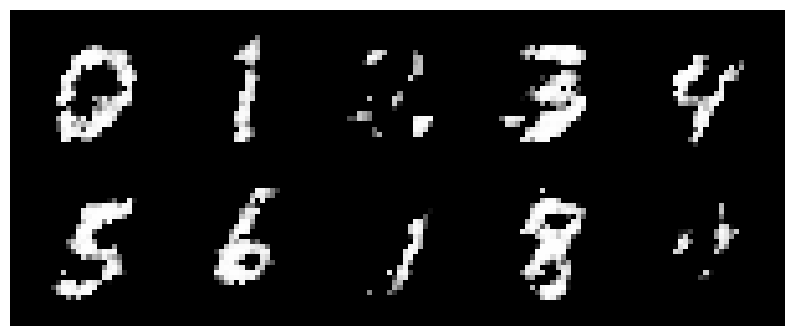

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999628].


Epoch: 1, Step: 3750, d_loss: 0.3772626221179962, g_loss: 3.0605454444885254


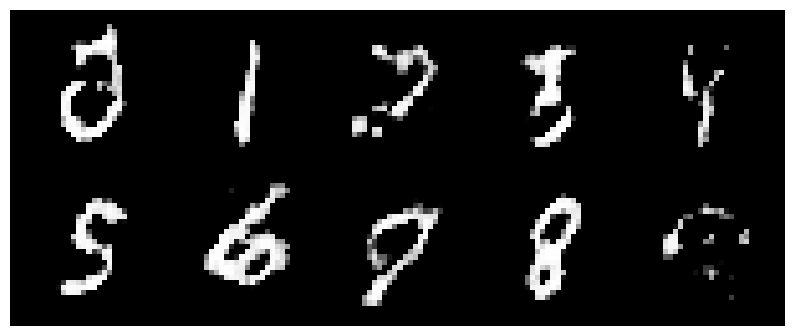

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999041].


Epoch: 2, Step: 5625, d_loss: 0.7849565744400024, g_loss: 2.0449843406677246


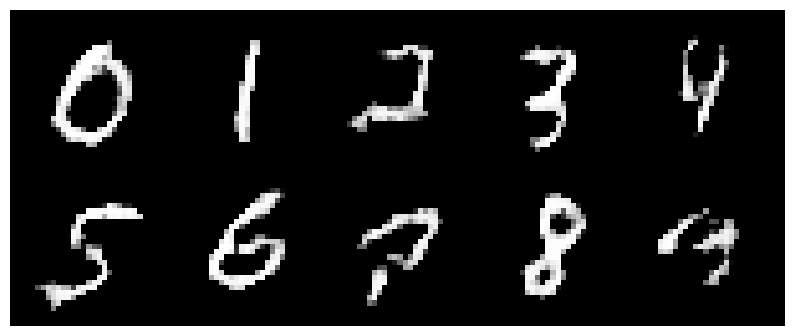

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997202].


Epoch: 3, Step: 7500, d_loss: 0.8790628910064697, g_loss: 1.765305995941162


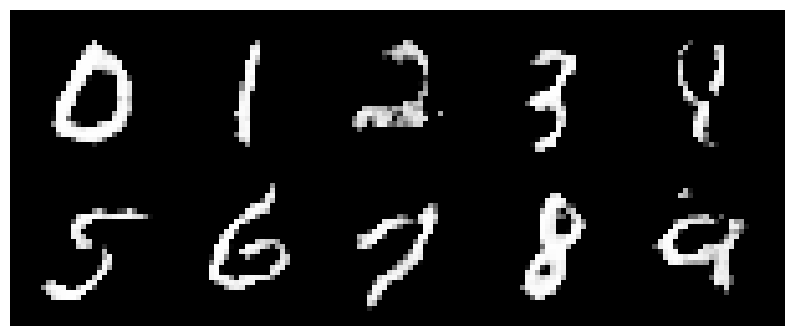

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996257].


Epoch: 4, Step: 9375, d_loss: 0.8637422323226929, g_loss: 1.4443273544311523


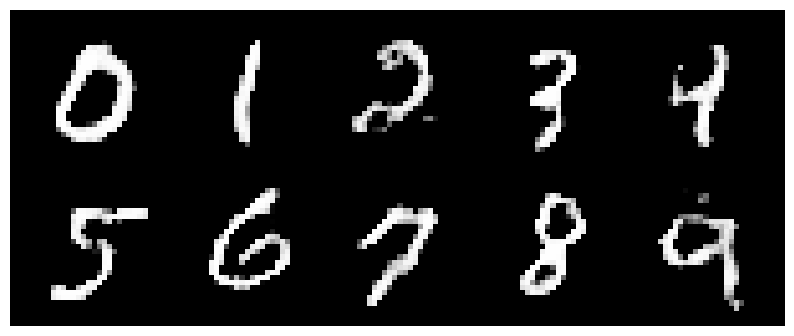

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997618].


Epoch: 5, Step: 11250, d_loss: 1.1208460330963135, g_loss: 1.4259189367294312


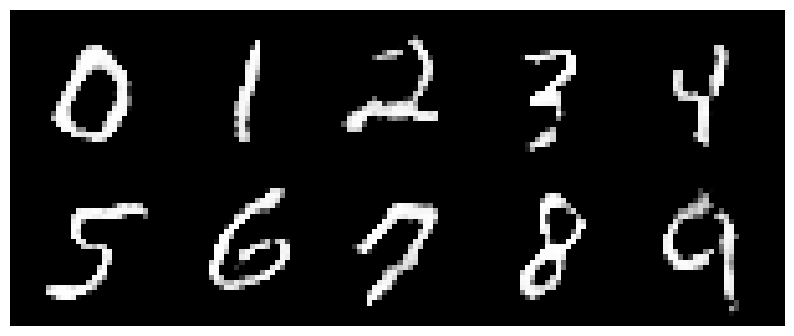

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99969035].


Epoch: 6, Step: 13125, d_loss: 1.1002197265625, g_loss: 1.269322156906128


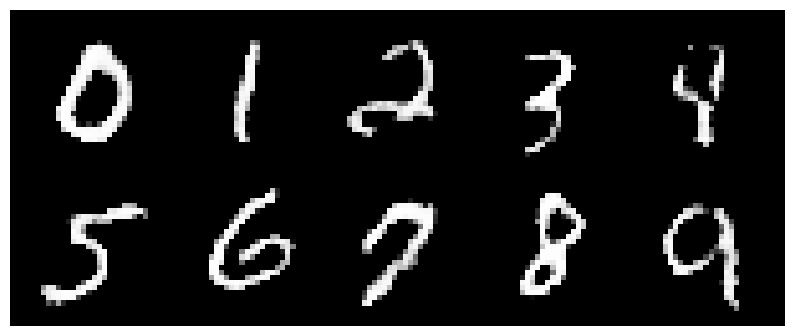

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996973].


Epoch: 7, Step: 15000, d_loss: 1.0738226175308228, g_loss: 1.1437417268753052


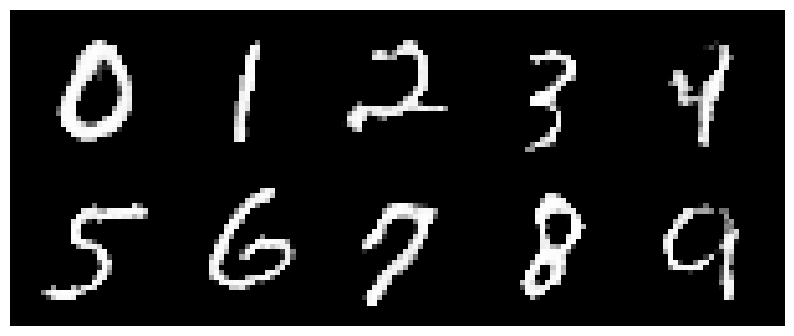

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996173].


Epoch: 8, Step: 16875, d_loss: 1.1911768913269043, g_loss: 1.1615102291107178


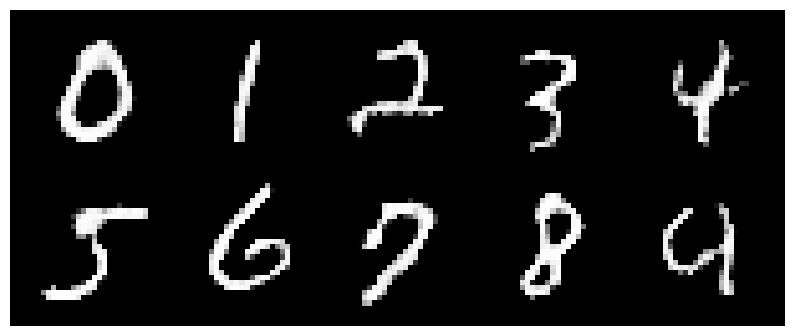

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99967176].


Epoch: 9, Step: 18750, d_loss: 1.016690731048584, g_loss: 1.0037567615509033


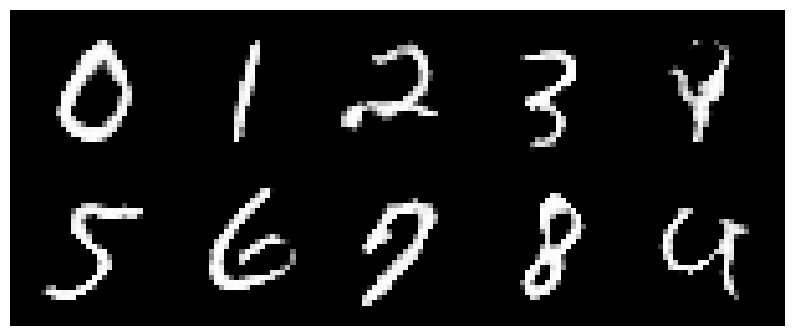

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9994286].


Epoch: 10, Step: 20625, d_loss: 1.218163251876831, g_loss: 1.1318402290344238


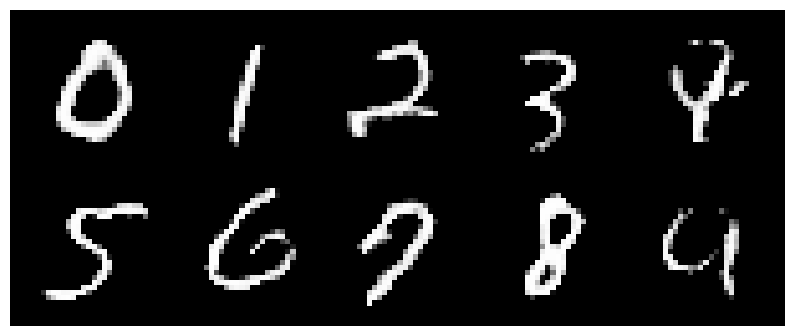

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996526].


Epoch: 11, Step: 22500, d_loss: 1.25140380859375, g_loss: 1.0488851070404053


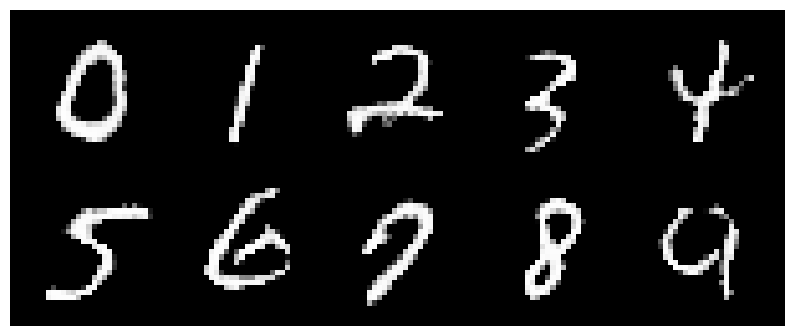

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99921674].


Epoch: 12, Step: 24375, d_loss: 1.1351954936981201, g_loss: 1.1455458402633667


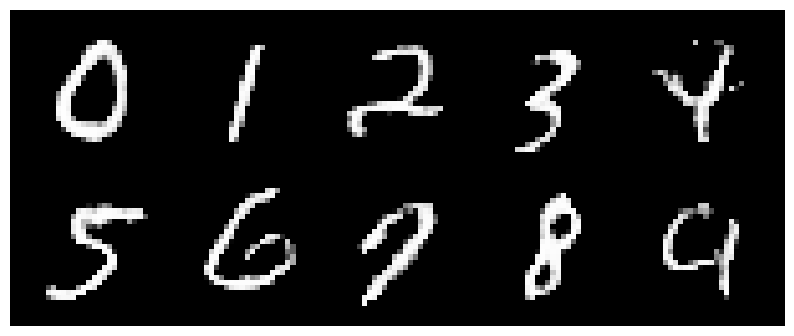

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995857].


Epoch: 13, Step: 26250, d_loss: 1.1929965019226074, g_loss: 1.0899837017059326


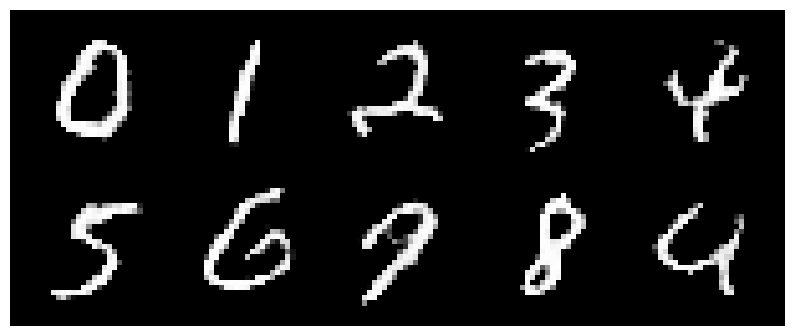

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9993886].


Epoch: 14, Step: 28125, d_loss: 1.105804204940796, g_loss: 0.8308365345001221


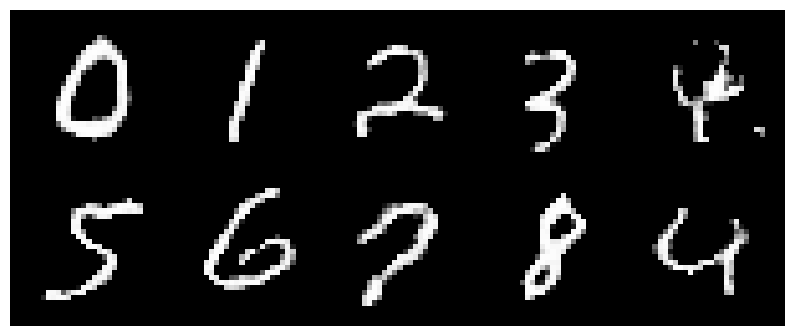

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99944395].


Epoch: 15, Step: 30000, d_loss: 1.1915383338928223, g_loss: 1.0541346073150635


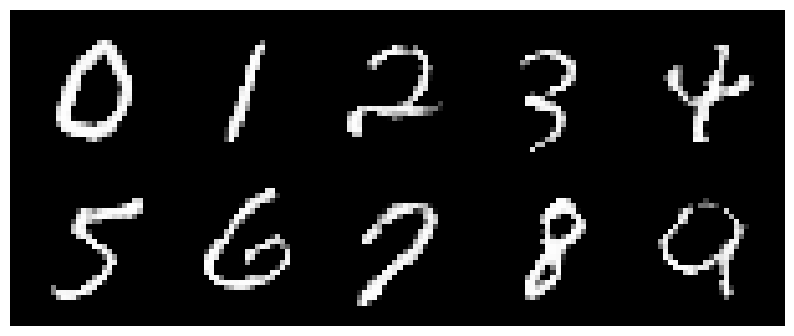

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996335].


Epoch: 16, Step: 31875, d_loss: 1.0255101919174194, g_loss: 0.8878281116485596


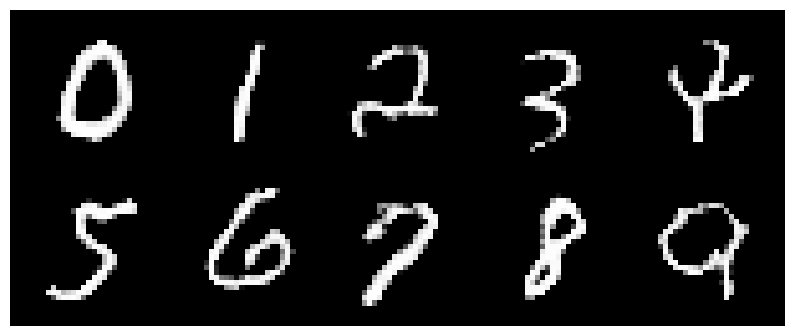

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9994036].


Epoch: 17, Step: 33750, d_loss: 1.1525700092315674, g_loss: 1.0504443645477295


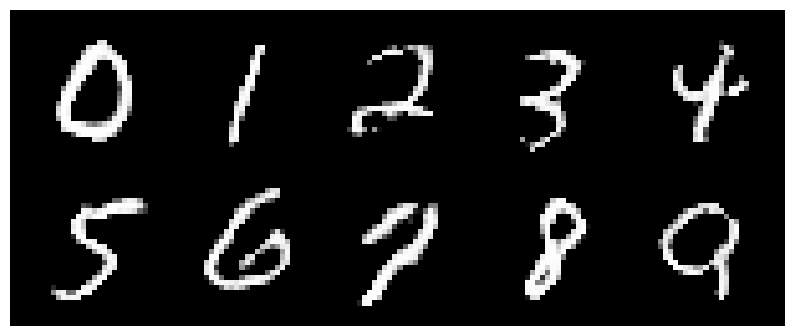

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997211].


Epoch: 18, Step: 35625, d_loss: 1.244385838508606, g_loss: 0.9015659093856812


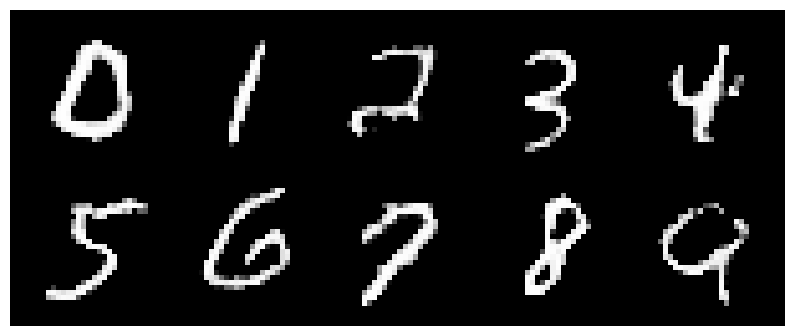

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99973655].


Epoch: 19, Step: 37500, d_loss: 1.2154278755187988, g_loss: 0.9882922768592834


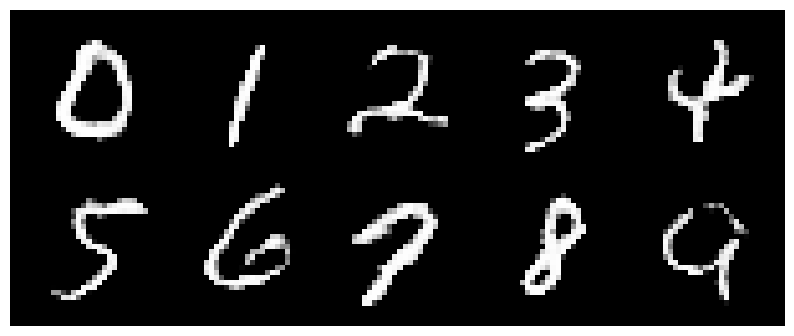

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9994139].


Epoch: 20, Step: 39375, d_loss: 1.3412559032440186, g_loss: 0.6946239471435547


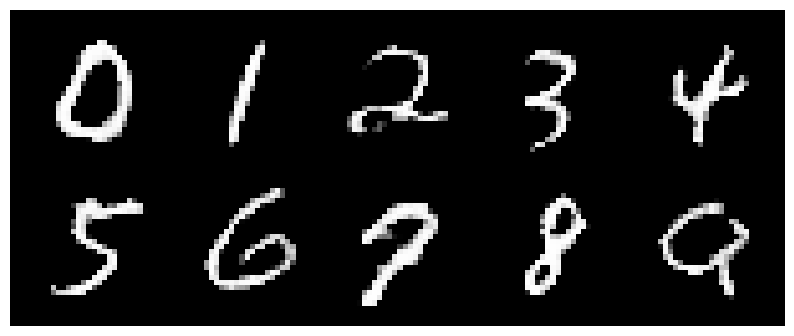

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99976045].


Epoch: 21, Step: 41250, d_loss: 1.2450957298278809, g_loss: 1.1244642734527588


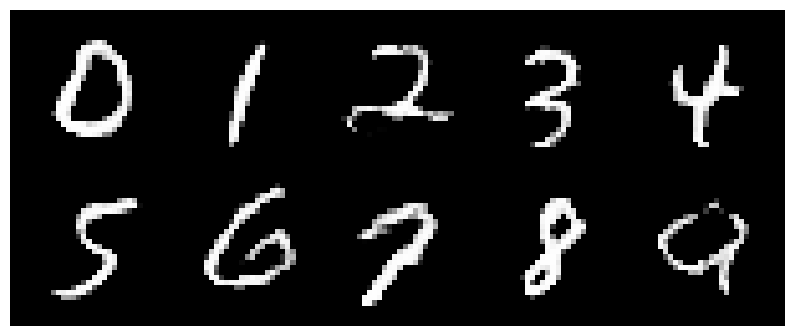

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9993928].


Epoch: 22, Step: 43125, d_loss: 1.1632202863693237, g_loss: 1.005729079246521


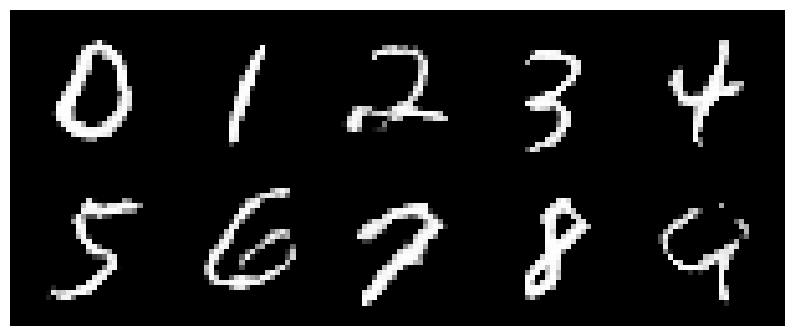

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997884].


Epoch: 23, Step: 45000, d_loss: 1.1996084451675415, g_loss: 1.187531590461731


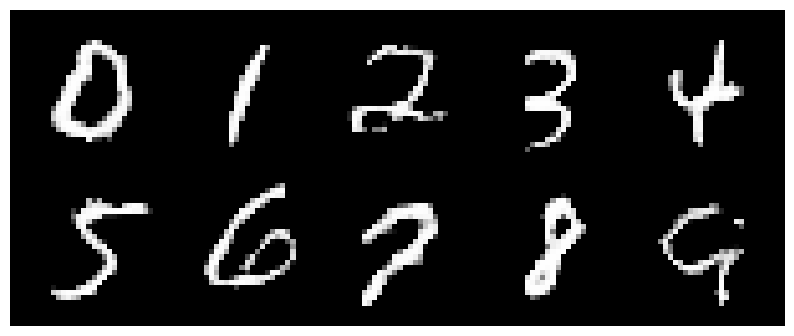

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995122].


Epoch: 24, Step: 46875, d_loss: 1.169668436050415, g_loss: 1.1335995197296143


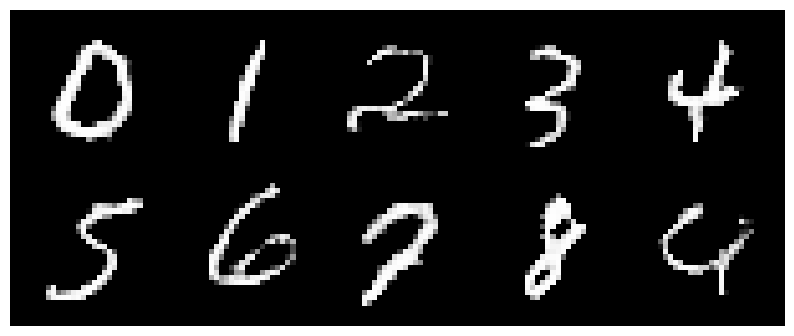

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99927896].


Epoch: 25, Step: 48750, d_loss: 1.2183464765548706, g_loss: 0.916263997554779


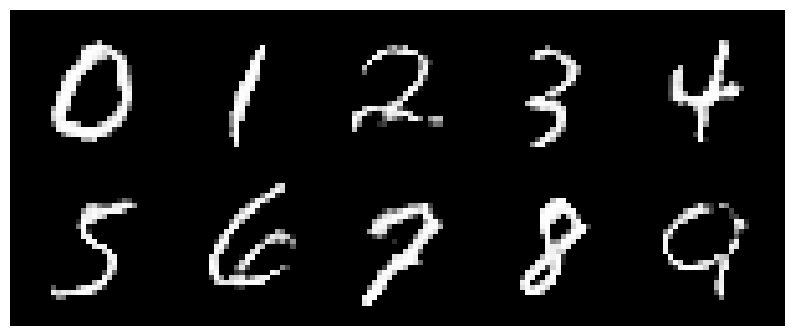

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996143].


Epoch: 26, Step: 50625, d_loss: 1.190306305885315, g_loss: 0.8876359462738037


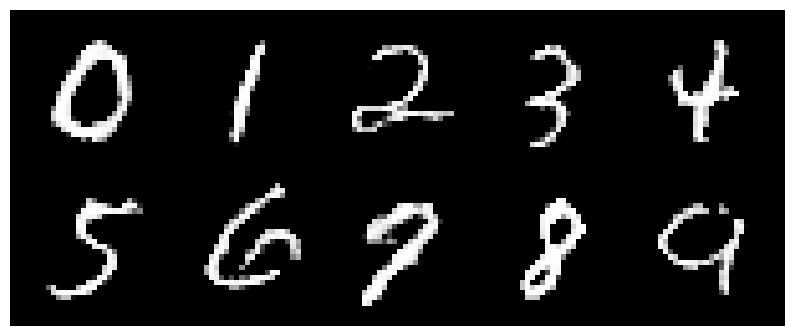

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995923].


Epoch: 27, Step: 52500, d_loss: 1.0113348960876465, g_loss: 1.0523779392242432


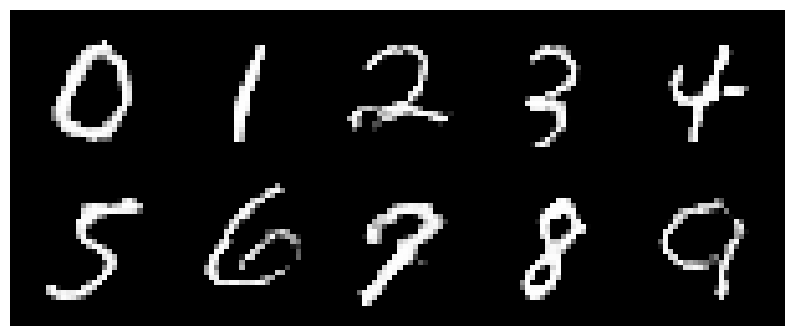

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99965054].


Epoch: 28, Step: 54375, d_loss: 1.2934240102767944, g_loss: 1.0484520196914673


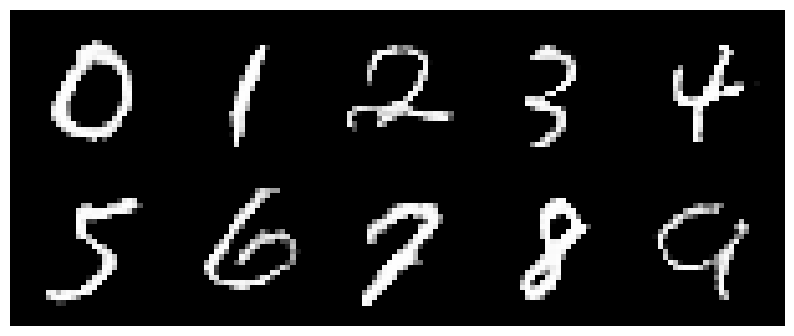

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995547].


Epoch: 29, Step: 56250, d_loss: 1.1550061702728271, g_loss: 1.0550563335418701


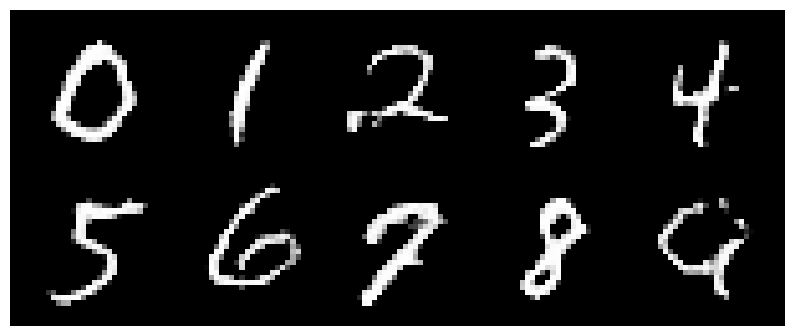

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997406].


Epoch: 30, Step: 58125, d_loss: 1.084786057472229, g_loss: 0.8759661316871643


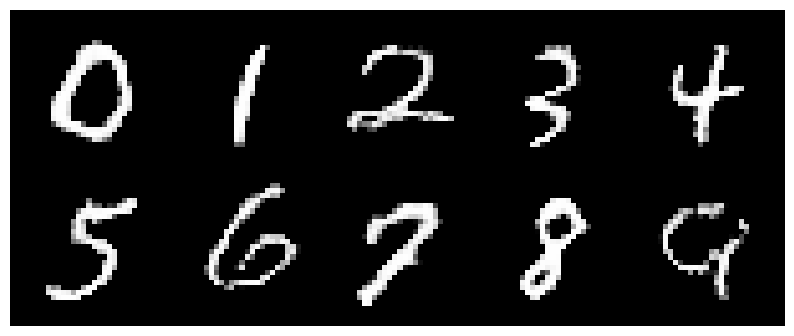

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99959344].


Epoch: 31, Step: 60000, d_loss: 1.1123698949813843, g_loss: 1.284149169921875


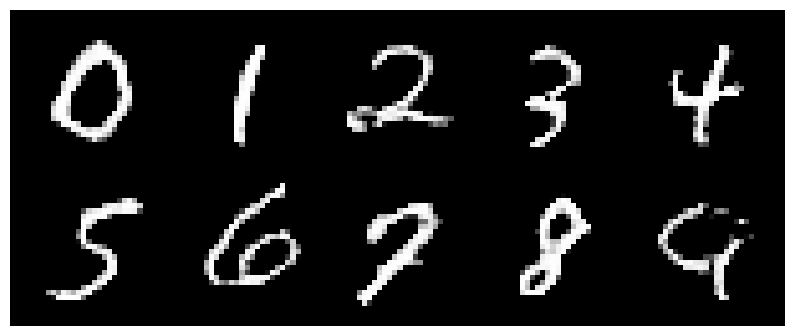

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997482].


Epoch: 32, Step: 61875, d_loss: 1.345552921295166, g_loss: 0.9611650109291077


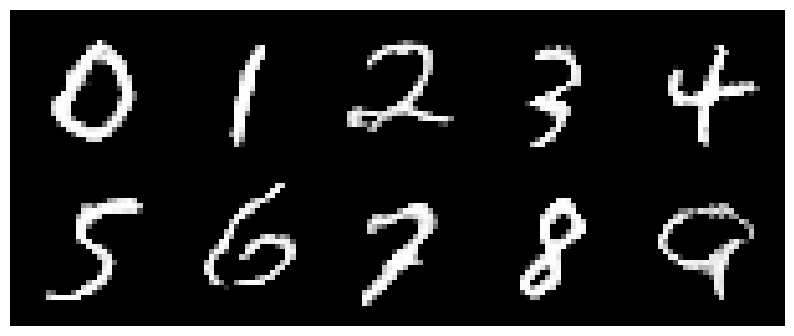

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.999812].


Epoch: 33, Step: 63750, d_loss: 1.1794805526733398, g_loss: 0.9957627058029175


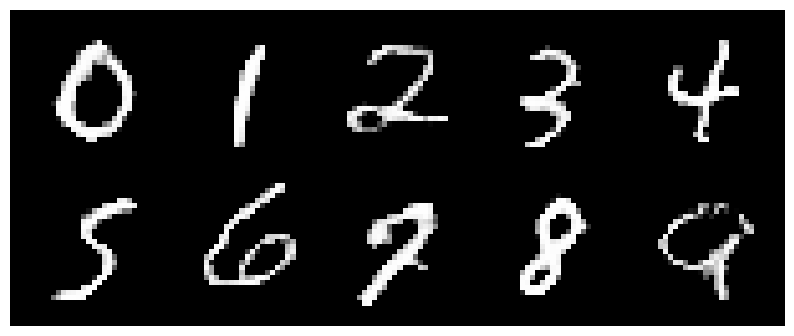

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997362].


Epoch: 34, Step: 65625, d_loss: 1.141258716583252, g_loss: 0.9835790395736694


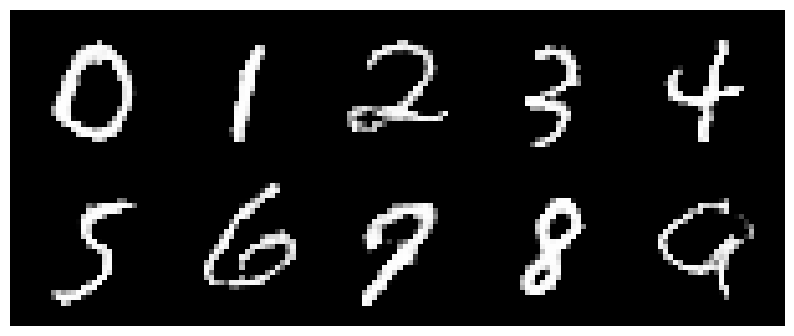

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9997491].


Epoch: 35, Step: 67500, d_loss: 1.2411757707595825, g_loss: 0.9637619256973267


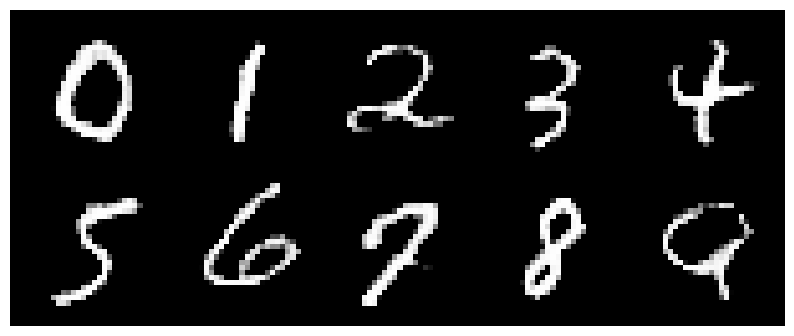

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99978393].


Epoch: 36, Step: 69375, d_loss: 1.2329810857772827, g_loss: 1.0214064121246338


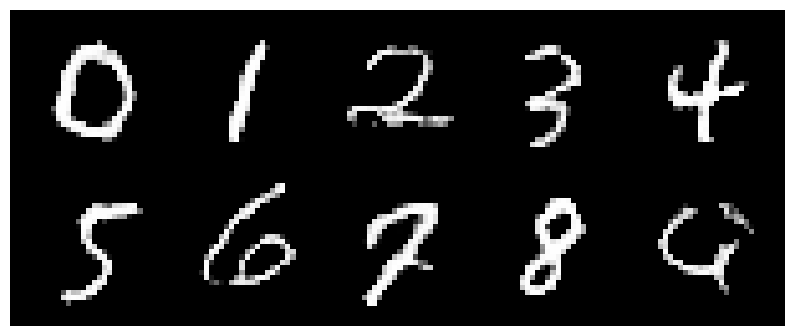

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9998578].


Epoch: 37, Step: 71250, d_loss: 1.1540629863739014, g_loss: 0.9218626022338867


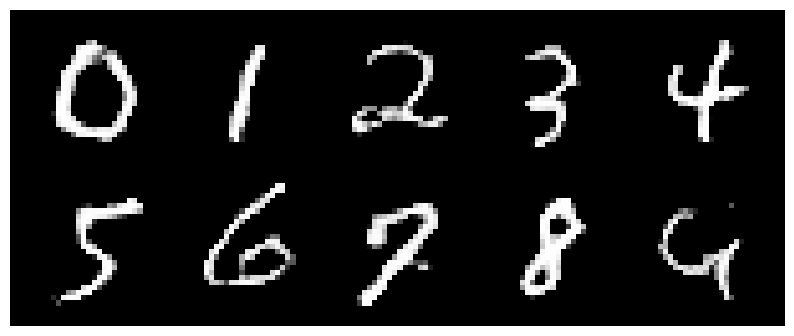

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99961615].


Epoch: 38, Step: 73125, d_loss: 1.1358542442321777, g_loss: 0.9059547781944275


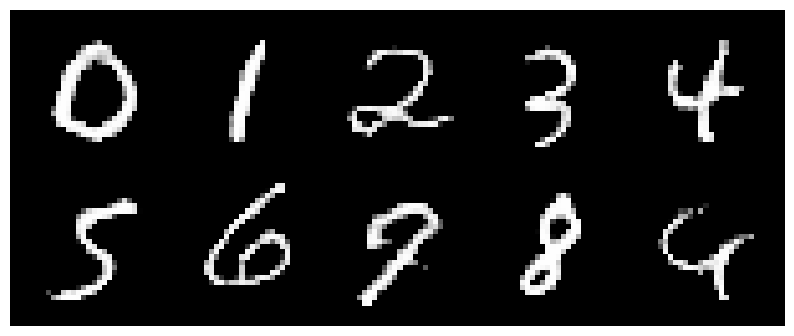

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99971616].


Epoch: 39, Step: 75000, d_loss: 1.1279611587524414, g_loss: 0.9640031456947327


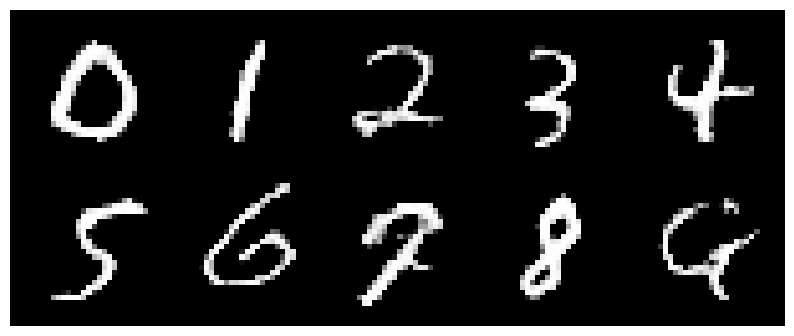

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9996879].


Epoch: 40, Step: 76875, d_loss: 1.133434772491455, g_loss: 1.034574031829834


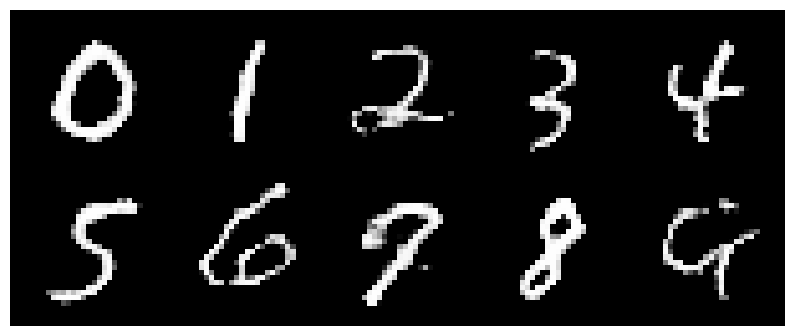

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99973845].


Epoch: 41, Step: 78750, d_loss: 1.2317497730255127, g_loss: 1.0511597394943237


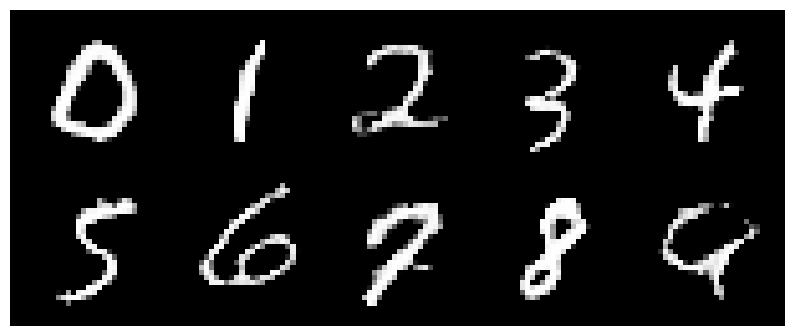

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99964803].


Epoch: 42, Step: 80625, d_loss: 1.4839611053466797, g_loss: 1.10990309715271


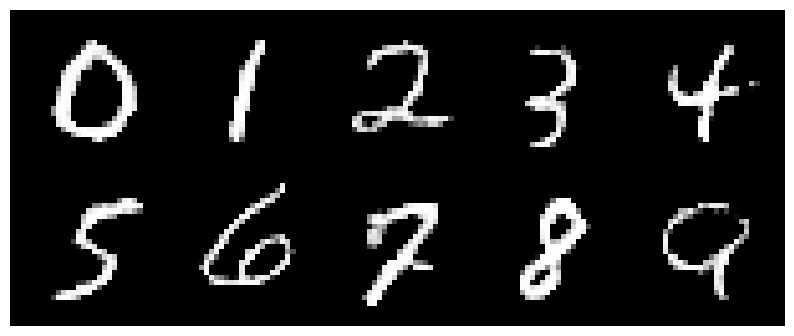

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99981606].


Epoch: 43, Step: 82500, d_loss: 1.1760663986206055, g_loss: 0.9117820858955383


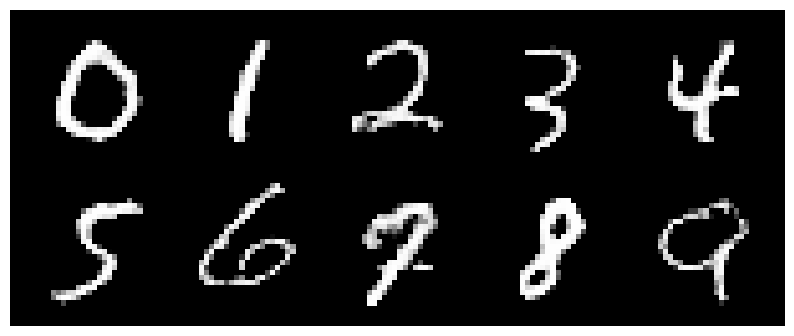

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9998268].


Epoch: 44, Step: 84375, d_loss: 1.2443592548370361, g_loss: 1.0187900066375732


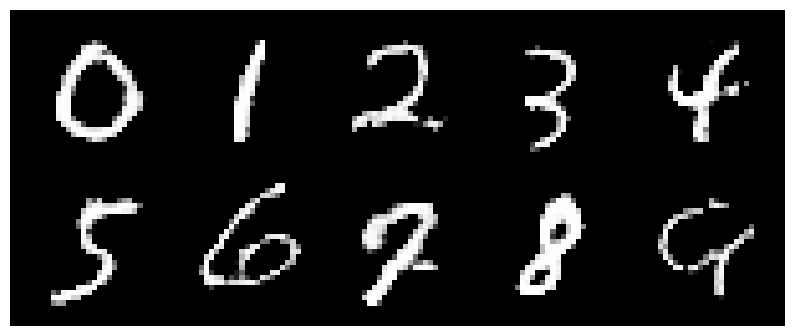

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9998366].


Epoch: 45, Step: 86250, d_loss: 1.215695858001709, g_loss: 1.0086534023284912


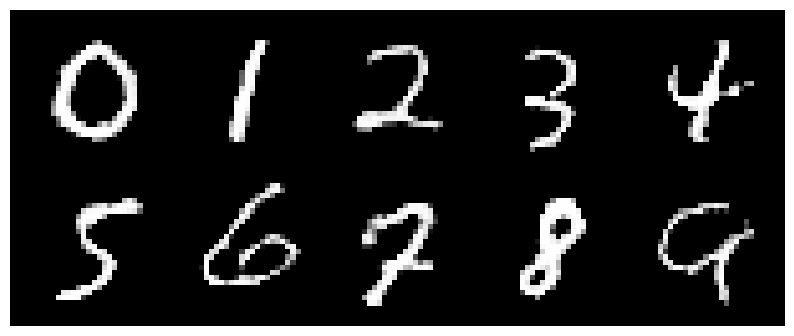

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9998827].


Epoch: 46, Step: 88125, d_loss: 1.2725750207901, g_loss: 1.0640835762023926


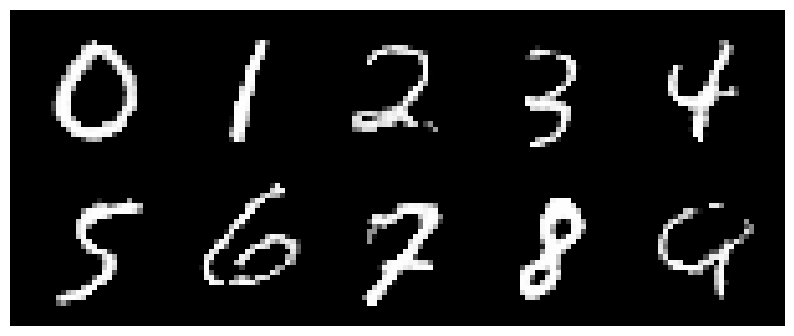

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9998258].


Epoch: 47, Step: 90000, d_loss: 1.1745802164077759, g_loss: 1.0491065979003906


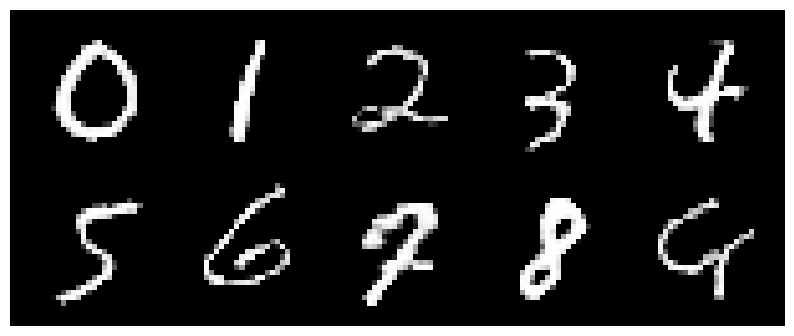

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9998431].


Epoch: 48, Step: 91875, d_loss: 1.2289594411849976, g_loss: 1.053179144859314


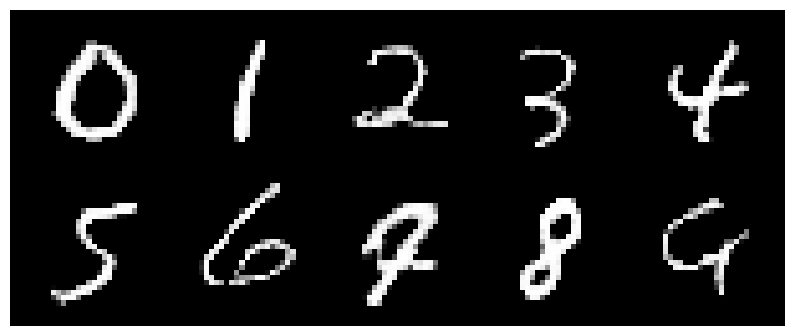

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99991965].


Epoch: 49, Step: 93750, d_loss: 1.2637686729431152, g_loss: 0.960081160068512


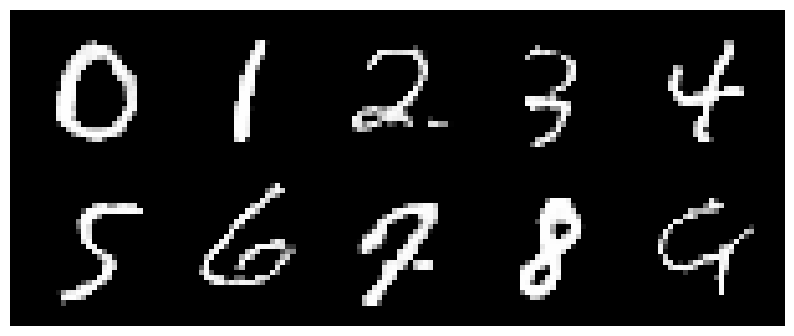

In [23]:
val_sample = Variable(torch.randn(10, 100)).cuda()
val_labels = Variable(torch.LongTensor(np.arange(10))).cuda()

num_epochs = 50
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
    print('Epoch: {}, Step: {}, d_loss: {}, g_loss: {}'.format(epoch, step, d_loss, g_loss))
    val_imgs = generator(val_sample, val_labels)
    
    grid = torchvision.utils.make_grid(val_imgs, nrow=5)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
    

In [24]:
torch.save(generator.state_dict(), 'generator_state.pt')

In [17]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [18]:
images = generator(z, labels).unsqueeze(1)

In [19]:
grid = make_grid(images, nrow=10, normalize=True)

(np.float64(-0.5), np.float64(301.5), np.float64(301.5), np.float64(-0.5))

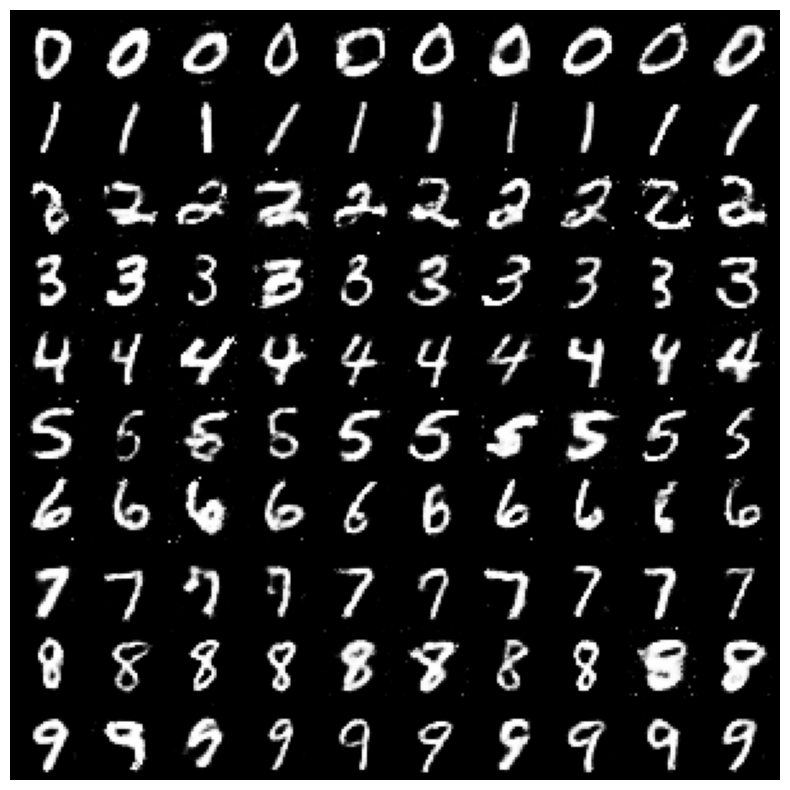

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data.cpu(), cmap='binary')
ax.axis('off')

In [22]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [24]:
generate_digit(generator, 8)